In [4]:
import torch
import torchvision
from torch.utils.data import dataloader

In [5]:
# transformation for PIL to tensor format
transformation = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

In [6]:
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transformation)
val_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transformation)

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.49MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.25MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.40MB/s]


In [7]:
num_features = 10
batch_size = 64
num_channels = 1
img_size = 28
patch_size = 7
num_patches = (img_size // patch_size) ** 2
embedding_dim = 64
attention_heads = 4
transformer_blocks = 4
mlp_hidden_nodes = 128
learning_rate = 0.001
epochs = 5

In [8]:
from torch.utils.data import dataloader
# define dataset batches
train_loader = dataloader.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = dataloader.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [9]:
import torch.nn as nn

In [10]:
# Part 1 : Patch Embeddings
class patchEmbedding(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embed = nn.Conv2d(num_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)

  def forward(self, x):
    x = self.patch_embed(x)
    x = x.flatten(2)
    x = x.transpose(1,2)

    return x


In [17]:
# Part 2 : Transformer Encoder
class TransformerEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embedding_dim)
    self.layer_norm2 = nn.LayerNorm(embedding_dim)
    self.multihead_attention = nn.MultiheadAttention(embedding_dim, attention_heads, batch_first=True)
    self.mlp = nn.Sequential(
        nn.Linear(embedding_dim, mlp_hidden_nodes),
        nn.GELU(),
        nn.Linear(mlp_hidden_nodes, embedding_dim)
    )

  # these process are followed according to the diagram of transformer encoder
  def forward(self, x):
    residual1 = x
    x = self.layer_norm1(x)
    x = self.multihead_attention(x,x,x)[0]
    x = x + residual1

    residual2 = x
    x = self.layer_norm2(x)
    x = self.mlp(x)
    x = x + residual2

    return x

In [18]:
# Part 3: MLP head
class MLPhead(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_norm1 = nn.LayerNorm(embedding_dim)
    self.mlp_head = nn.Linear(embedding_dim, num_features)

  def forward(self, x):
    x = self.layer_norm1(x)
    x = self.mlp_head(x)

    return x

In [19]:
class VisionTransformer(nn.Module):
  def __init__(self):
    super().__init__()
    self.patch_embedding = patchEmbedding()
    self.cls_token = nn.Parameter(torch.rand(1,1,embedding_dim))
    self.positional_embedding = nn.Parameter(torch.rand(1,1+num_patches, embedding_dim))
    self.transformer_encoder = nn.Sequential(*[TransformerEncoder() for _ in range(transformer_blocks)])
    self.mlp_head = MLPhead()

  def forward(self, x):
    x = self.patch_embedding(x)
    B = x.size(0)
    classToken = self.cls_token.expand(B,-1,-1)
    x = torch.cat((classToken, x), dim=1)
    x = x + self.positional_embedding
    x = self.transformer_encoder(x)
    x = x[:,0]
    x = self.mlp_head(x)

    return x

In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VisionTransformer().to(device)

optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [21]:
# training loop

for epoch in range(epochs):
  model.train()
  total_loss = 0
  correct_epoch = 0
  total_epoch = 0

  print(f"epoch {epoch+1}\n")

  for batch_idx, (images, labels) in enumerate(train_loader):
    images, labels = images.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    pred = outputs.argmax(dim=1)
    correct = (pred == labels).sum().item()

    accuracy = 100 * correct/labels.size(0)

    correct_epoch += correct
    total_epoch += labels.size(0)

    if batch_idx % 100 == 0:
      print(f"Batch {batch_idx+1 : 3d}: loss = {loss.item():.4f}, Accuracy = {accuracy:.2f}%")

  epoch_accuracy = 100 * correct_epoch/total_epoch
  print(f"Epoch {epoch+1}: loss = {total_loss/len(train_loader):.4f}, Accuracy = {epoch_accuracy:.2f}%")

epoch 1

Batch   1: loss = 2.4233, Accuracy = 9.38%
Batch  101: loss = 0.5488, Accuracy = 78.12%
Batch  201: loss = 0.2300, Accuracy = 95.31%
Batch  301: loss = 0.2362, Accuracy = 95.31%
Batch  401: loss = 0.2600, Accuracy = 90.62%
Batch  501: loss = 0.0977, Accuracy = 96.88%
Batch  601: loss = 0.1153, Accuracy = 96.88%
Batch  701: loss = 0.1375, Accuracy = 93.75%
Batch  801: loss = 0.0947, Accuracy = 96.88%
Batch  901: loss = 0.0305, Accuracy = 100.00%
Epoch 1: loss = 0.3296, Accuracy = 89.76%
epoch 2

Batch   1: loss = 0.1296, Accuracy = 96.88%
Batch  101: loss = 0.0887, Accuracy = 95.31%
Batch  201: loss = 0.1657, Accuracy = 96.88%
Batch  301: loss = 0.1300, Accuracy = 96.88%
Batch  401: loss = 0.0668, Accuracy = 98.44%
Batch  501: loss = 0.0365, Accuracy = 100.00%
Batch  601: loss = 0.0417, Accuracy = 98.44%
Batch  701: loss = 0.1573, Accuracy = 92.19%
Batch  801: loss = 0.1439, Accuracy = 96.88%
Batch  901: loss = 0.0460, Accuracy = 100.00%
Epoch 2: loss = 0.1234, Accuracy = 96.23

In [22]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
  for images, labels in val_loader:
    images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    pred = outputs.argmax(dim=1)
    correct += (pred == labels).sum().item()
    total += labels.size(0)

test_accuracy = 100 * correct/total
print(f"Accuracy = {test_accuracy:.2f}%")

Accuracy = 97.82%


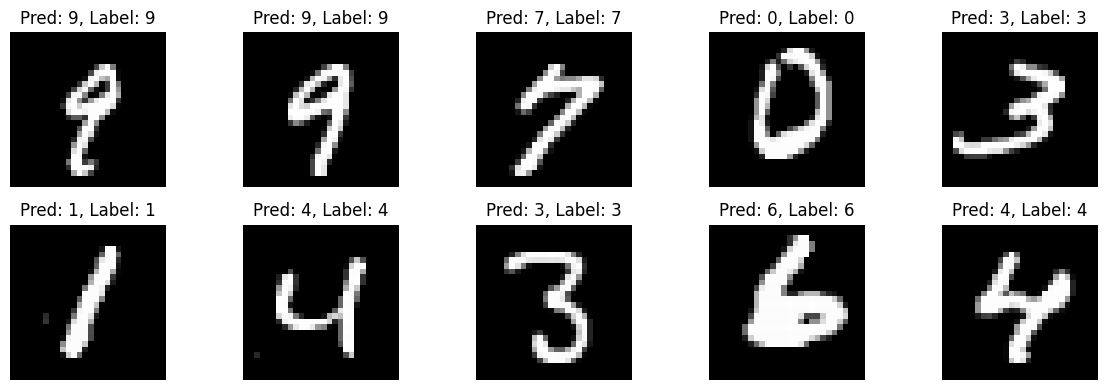

In [24]:
import matplotlib.pyplot as plt

model.eval()
images, labels = next(iter(val_loader))
images, labels = images.to(device), labels.to(device)
with torch.no_grad():
  outputs = model(images)
  pred = outputs.argmax(dim=1)

# move cpu for plotting
images = images.cpu()
pred = pred.cpu()
labels = labels.cpu()

# plot first 10 images
plt.figure(figsize=(12,4))
for i in range(10):
  plt.subplot(2,5,i+1)
  plt.imshow(images[i].squeeze(), cmap='gray')
  plt.title(f"Pred: {pred[i].item()}, Label: {labels[i].item()}")
  plt.axis('off')

plt.tight_layout()
plt.show()